## Import Libraries

In [156]:
import os
import numpy as np 
import pandas as pd 
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

## Read CSV File

In [2]:
# CSV file have inconsistent file structure.
# file has more column separators (like commas) on some rows than there are actual column headers (which are 27).

df = pd.read_csv('covid_clinical_trials.csv', usecols=range(27))

In [3]:
df.shape

(5786, 27)

In [4]:
df.columns

Index(['Rank', 'NCT Number', 'Title', 'Acronym', 'Status', 'Study Results',
       'Conditions', 'Interventions', 'Outcome Measures',
       'Sponsor/Collaborators', 'Gender', 'Age', 'Phases', 'Enrollment',
       'Funded Bys', 'Study Type', 'Study Designs', 'Other IDs', 'Start Date',
       'Primary Completion Date', 'Completion Date', 'First Posted',
       'Results First Posted', 'Last Update Posted', 'Locations',
       'Study Documents', 'URL'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5786 entries, 0 to 5785
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Rank                     5786 non-null   object
 1   NCT Number               5786 non-null   object
 2   Title                    5786 non-null   object
 3   Acronym                  2483 non-null   object
 4   Status                   5786 non-null   object
 5   Study Results            5786 non-null   object
 6   Conditions               5786 non-null   object
 7   Interventions            4900 non-null   object
 8   Outcome Measures         5751 non-null   object
 9   Sponsor/Collaborators    5786 non-null   object
 10  Gender                   5776 non-null   object
 11  Age                      5786 non-null   object
 12  Phases                   3325 non-null   object
 13  Enrollment               5752 non-null   object
 14  Funded Bys               5786 non-null  

## Convert Object to Numeric

In [6]:
numeric_columns = ['Rank', 'Enrollment']

for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(df[['Rank', 'Enrollment']].dtypes)
print(df[['Rank', 'Enrollment']].head())

Rank          float64
Enrollment    float64
dtype: object
   Rank  Enrollment
0   1.0      1000.0
1   2.0        60.0
2   3.0       500.0
3   4.0      2500.0
4   5.0        50.0


## Convert Object to DateTime

In [7]:
date_columns = ['Start Date', 'Primary Completion Date', 'Completion Date', 'First Posted', 'Results First Posted', 'Last Update Posted']

for col in date_columns:
    df[col] = pd.to_datetime(df[col], format="%B %d, %Y", errors='coerce')

print(df[['Start Date', 'Primary Completion Date', 'Completion Date', 'First Posted', 'Results First Posted', 'Last Update Posted']].dtypes)
print(df[['Start Date', 'Primary Completion Date', 'Completion Date', 'First Posted', 'Results First Posted', 'Last Update Posted']].head())

Start Date                 datetime64[ns]
Primary Completion Date    datetime64[ns]
Completion Date            datetime64[ns]
First Posted               datetime64[ns]
Results First Posted       datetime64[ns]
Last Update Posted         datetime64[ns]
dtype: object
  Start Date Primary Completion Date Completion Date First Posted  \
0 2020-11-09              2020-12-22      2021-04-30   2021-03-08   
1 2020-11-02              2020-12-15      2021-01-29   2020-10-20   
2 2020-05-07              2021-06-15      2021-06-15   2020-05-20   
3 2020-05-25              2020-07-31      2020-08-31   2020-06-04   
4 2020-05-05                     NaT             NaT   2020-05-20   

  Results First Posted Last Update Posted  
0                  NaT         2021-03-08  
1                  NaT         2020-10-20  
2                  NaT         2020-11-09  
3                  NaT         2020-06-04  
4                  NaT         2020-06-04  


## Find Rows where "Rank" is "nan"

In [9]:
# df.iloc[892]

In [10]:
dummy_rows = df[df['Rank'].isna()]

for index, row in dummy_rows.iterrows():
    print(f"Index: {index}, Rank: {row['Rank']}")

Index: 892, Rank: nan
Index: 5544, Rank: nan
Index: 5731, Rank: nan


## Drop rows where "Rank" is "nan"

In [11]:
df.shape

(5786, 27)

In [12]:
df.dropna(subset=['Rank'], inplace=True)

In [13]:
df.shape

(5783, 27)

In [14]:
blank_rows_nan = df[df.isnull().all(axis=1)]
blank_rows_nan_indices = blank_rows_nan.index
blank_rows_nan_indices.tolist()
# df_cleaned_nan = df.dropna(how='all')

[]

## Remove Leading and Trailing Spaces in Objects Columns (Here "Location")

In [15]:
object_cols = df.select_dtypes(include=['object']).columns

print("Columns with object dtype: \n\n", object_cols.tolist())

for col in object_cols:
    has_leading_space = df[col].astype(str).str.startswith(' ').any()
    has_trailing_space = df[col].astype(str).str.endswith(' ').any()

    if has_leading_space:
        print(f"\nColumn '{col}' has leading blank spaces.")
    if has_trailing_space:
        print(f"Column '{col}' has trailing blank spaces.")

    if has_leading_space or has_trailing_space:
        # Trim leading and trailing spaces
        df[col] = df[col].astype(str).str.strip()
        print(f"Column '{col}' has been trimmed.")

Columns with object dtype: 

 ['NCT Number', 'Title', 'Acronym', 'Status', 'Study Results', 'Conditions', 'Interventions', 'Outcome Measures', 'Sponsor/Collaborators', 'Gender', 'Age', 'Phases', 'Funded Bys', 'Study Type', 'Study Designs', 'Other IDs', 'Locations', 'Study Documents', 'URL']
Column 'Locations' has trailing blank spaces.
Column 'Locations' has been trimmed.


## Remove dummy entries from "Gender" Column

In [16]:
# df['Gender'].value_counts()

In [17]:
# This code will remove rows from your DataFrame where the 'gender' column is not 'All', 'Male', or 'Female'.

df.drop(df[~df['Gender'].isin(['All', 'Male', 'Female'])].index, inplace=True)

In [18]:
# df['Gender'].value_counts()

## Remove Unwanted Columns

In [19]:
columns_to_drop = ['URL']
df.drop(columns=columns_to_drop, inplace=True)

## Save Cleaned df as Fresh CSV

In [20]:
df.to_csv('covid_clinical_trials_cleaned.csv', index=False)

In [21]:
# def is_blank(row):
#     return row.isnull().all() or row.astype(str).eq('').all()

# blank_rows_mask = df.apply(is_blank, axis=1)
# df_cleaned = df[~blank_rows_mask]
# df_cleaned.to_csv('covid_clinical_trials_cleaned.csv', index=False, lineterminator='\n')

In [22]:
df.head(2).T

,0,1
Rank,1.0,2.0
NCT Number,NCT04785898,NCT04595136
Title,Diagnostic Performance of the ID Now™ COVID-19...,Study to Evaluate the Efficacy of COVID19-0001...
Acronym,COVID-IDNow,COVID-19
Status,"Active, not recruiting",Not yet recruiting
Study Results,No Results Available,No Results Available
Conditions,Covid19,SARS-CoV-2 Infection
Interventions,Diagnostic Test: ID Now™ COVID-19 Screening Test,Drug: Drug COVID19-0001-USR|Drug: normal saline
Outcome Measures,Evaluate the diagnostic performance of the ID ...,Change on viral load results from baseline aft...
Sponsor/Collaborators,Groupe Hospitalier Paris Saint Joseph,United Medical Specialties


## Object Columns

In [23]:
df.select_dtypes(include = 'object').columns

Index(['NCT Number', 'Title', 'Acronym', 'Status', 'Study Results',
       'Conditions', 'Interventions', 'Outcome Measures',
       'Sponsor/Collaborators', 'Gender', 'Age', 'Phases', 'Funded Bys',
       'Study Type', 'Study Designs', 'Other IDs', 'Locations',
       'Study Documents'],
      dtype='object')

## Columns excluding Objects

In [24]:
df.select_dtypes(exclude = 'object').columns

Index(['Rank', 'Enrollment', 'Start Date', 'Primary Completion Date',
       'Completion Date', 'First Posted', 'Results First Posted',
       'Last Update Posted'],
      dtype='object')

## Percentage of missing data in each features/columns and its barplot

In [25]:
# Detecting (Percentage) Missing Data
missing_data = df.isnull().mean() * 100
missing_data

Rank                        0.000000
NCT Number                  0.000000
Title                       0.000000
Acronym                    57.076044
Status                      0.000000
Study Results               0.000000
Conditions                  0.000000
Interventions              15.312662
Outcome Measures            0.571627
Sponsor/Collaborators       0.000000
Gender                      0.000000
Age                         0.000000
Phases                     42.456262
Enrollment                  0.554305
Funded Bys                  0.000000
Study Type                  0.000000
Study Designs               0.571627
Other IDs                   0.017322
Start Date                  8.972804
Primary Completion Date    25.290144
Completion Date            26.381431
First Posted                0.000000
Results First Posted       99.376407
Last Update Posted          0.000000
Locations                   0.000000
Study Documents            96.847393
dtype: float64

In [26]:
# len(missing_data)
# 26

In [27]:
# min(40, len(missing_data))
# 26

In [28]:
# type(missing_data)
# pandas.core.series.Series

In [29]:
missing_data.keys()[:26].tolist()

['Rank',
 'NCT Number',
 'Title',
 'Acronym',
 'Status',
 'Study Results',
 'Conditions',
 'Interventions',
 'Outcome Measures',
 'Sponsor/Collaborators',
 'Gender',
 'Age',
 'Phases',
 'Enrollment',
 'Funded Bys',
 'Study Type',
 'Study Designs',
 'Other IDs',
 'Start Date',
 'Primary Completion Date',
 'Completion Date',
 'First Posted',
 'Results First Posted',
 'Last Update Posted',
 'Locations',
 'Study Documents']

In [30]:
missing_data.values[:26].tolist()

[0.0,
 0.0,
 0.0,
 57.07604365148104,
 0.0,
 0.0,
 0.0,
 15.31266239390265,
 0.5716265373289451,
 0.0,
 0.0,
 0.0,
 42.4562619088862,
 0.5543045210462498,
 0.0,
 0.0,
 0.5716265373289451,
 0.017322016282695307,
 8.972804434436169,
 25.290143772735146,
 26.38143079854495,
 0.0,
 99.37640741382296,
 0.0,
 0.0,
 96.84739303654946]

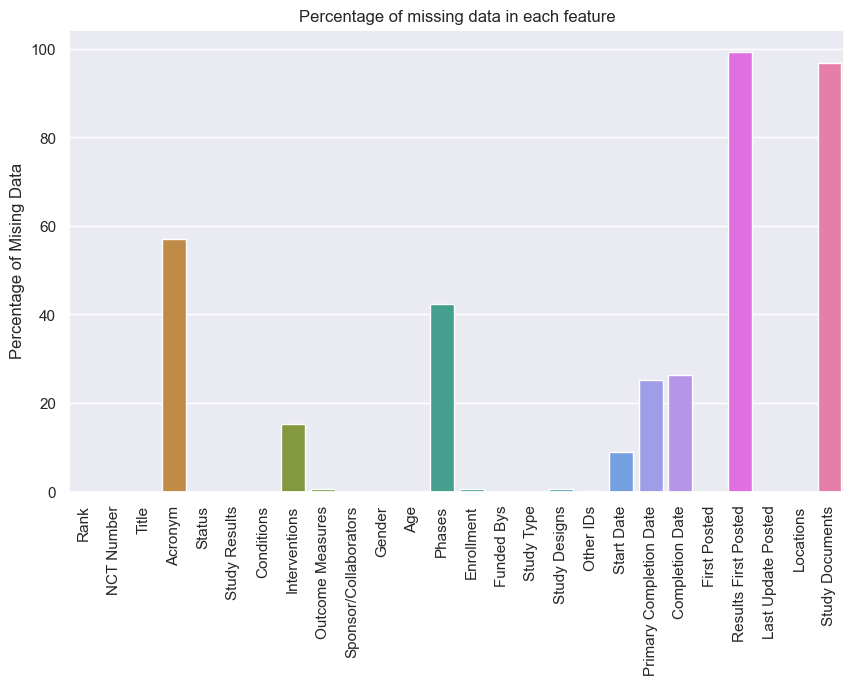

In [31]:
# Visualize data without calculating

def visualize_data(data, caption='', ylabel='Percentage of Mising Data'):
    sns.set(rc={'figure.figsize':(10, 6)})
    plt.xticks(rotation=90)
    missing_data_rank = data.keys()[:min(40, len(data))].tolist()
    missing_data_rank_pct = data.values[:min(40, len(data))].tolist()
    fig = sns.barplot(x=missing_data_rank, hue=missing_data_rank, y=missing_data_rank_pct).set_title(caption)
    plt.ylabel(ylabel)
    plt.show()

visualize_data(missing_data, 'Percentage of missing data in each feature')

## Unique Value Counts of each features and barplot

In [32]:
df_value_counts = []
df_cols = df.columns.tolist()
for col in df_cols:
    df_value_counts.append(df[col].value_counts().count())

In [33]:
df_unique_value_counts = pd.Series(df_value_counts, index=df_cols)

In [34]:
# print(df_unique_value_counts.keys())
# print()
# print(df_unique_value_counts.values)

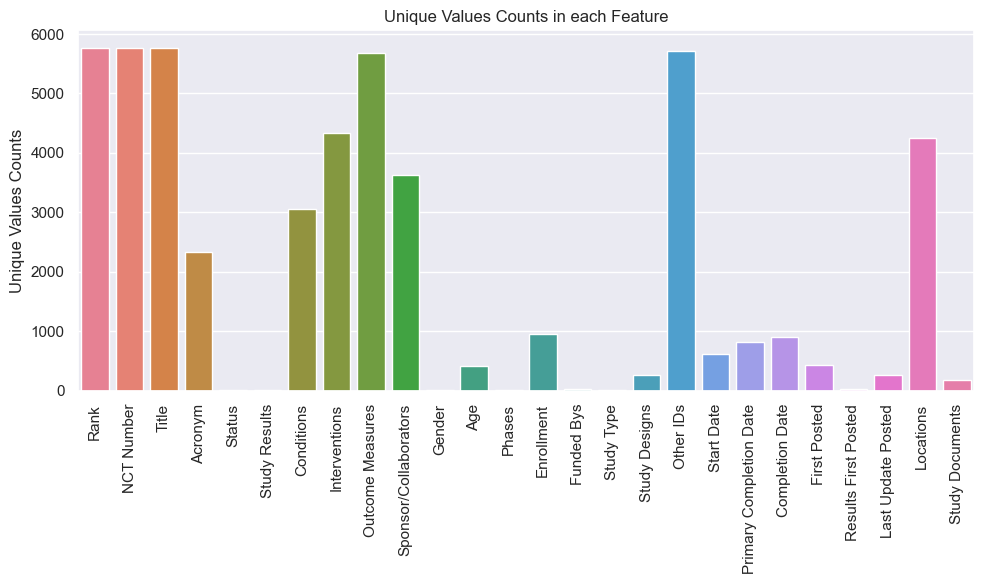

In [35]:
def visualize_data(data, caption='', ylabel='Unique Values Counts'):
    sns.set(rc={'figure.figsize':(10, 6)})
    plt.xticks(rotation=90)
    data_keys = data.keys()[:min(40, len(data))].tolist()
    data_values = data.values[:min(40, len(data))].tolist()
    ax = sns.barplot(x=data_keys, hue=data_keys, y=data_values).set_title(caption)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

visualize_data(df_unique_value_counts, 'Unique Values Counts in each Feature')

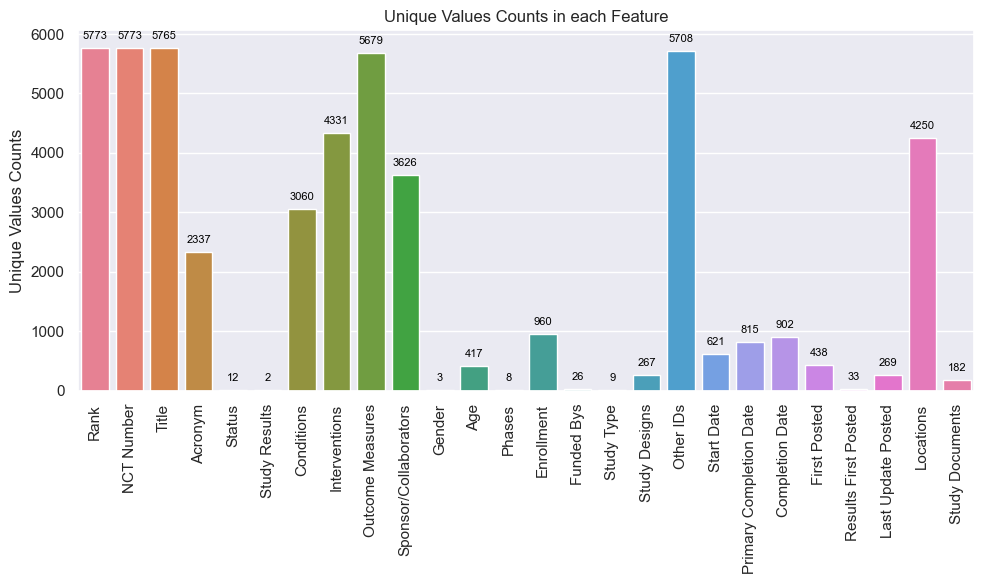

In [36]:
def visualize_data(data, caption='', ylabel='Unique Values Counts'):
    sns.set(rc={'figure.figsize': (10, 6)})
    plt.xticks(rotation=90)
    
    # Get the keys and values for the bar plot
    data_keys = data.keys()[:min(40, len(data))].tolist()
    data_values = data.values[:min(40, len(data))].tolist()
    
    # Create the bar plot
    ax = sns.barplot(x=data_keys, hue=data_keys, y=data_values, legend=False)
    ax.set_title(caption)
    plt.ylabel(ylabel)
    
    # Annotate the bars with their integer values
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',  # Convert to int for annotation
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', 
                    fontsize=8, color='black', 
                    xytext=(0, 5),  # Offset the text slightly above the bar
                    textcoords='offset points')
    
    plt.tight_layout()
    plt.show()

# Example usage
visualize_data(df_unique_value_counts, 'Unique Values Counts in each Feature')

## Extract countries name from "Location" column and add a new column "Country"

In [37]:
print(df.shape[0])
print(df.shape[1])

5773
26


In [38]:
df.Locations.iloc[66]

"Semmelweis University's Department of Pulmonology, Budapest, Hungary"

In [39]:
df.Locations.iloc[66].split(',')

["Semmelweis University's Department of Pulmonology", ' Budapest', ' Hungary']

In [40]:
df.Locations.iloc[66].split(',')[-1]

' Hungary'

In [41]:
# Extract a new feature form The 'Location' which is the 'country'

countries = [ str(df.Locations.iloc[i]).split(',')[-1] for i in range(df.shape[0])]

In [42]:
len(countries)

5773

In [43]:
countries[0:10]

[' France',
 ' Colombia',
 ' San Marino',
 ' Hong Kong',
 ' France',
 ' Vietnam',
 ' United States',
 ' India',
 ' Israel',
 ' Chile']

In [44]:
df['Country'] = countries

In [45]:
df.Country.value_counts()[:10]

Country
 United States     1266
 France             647
nan                 583
 United Kingdom     303
 Italy              234
 Spain              233
 Turkey             218
 Canada             202
 Egypt              191
 China              171
Name: count, dtype: int64

## Find relationship between two columns "Acronym" and "Country" based on null values

 - Missing data can be classified to one of these categories
    1) Missing Completely At Random (MCAR)
    2) Missing At Random (MAR)
    3) Not Missing At Random (NMAR)
 
 - After inspecting the relation between the missing values in Acronym and Country we can conclude that there is a sort of relation between these two features, so we can say that Data is Missing At Random (MAR)

In [53]:
print( df['Acronym'].isnull().sum() )
print( df['Acronym'].shape[0] )
print( df['Acronym'].isnull().sum() / df['Acronym'].shape[0] )
print( df['Acronym'].isnull().mean() )

3295
5773
0.5707604365148103
0.5707604365148103


* df['Acronym'].isnull().mean() == Count of True + Count of False / Sum of (True as 1) + Sum of (False as 0)
* Count of True + Count of False / Sum of (True as 1) + Sum of (False as 0) == Number of True values / Total number of values

In [46]:
df.Acronym.nunique()

2337

In [47]:
df.Acronym.value_counts()

Acronym
COVID-19        47
PROTECT          7
CORONA           6
SCOPE            5
Covid-19         5
                ..
ASD              1
VICO             1
LICORNE          1
LOSVID           1
MindMyMindFU     1
Name: count, Length: 2337, dtype: int64

In [48]:
df.Acronym.isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
5781     True
5782     True
5783     True
5784    False
5785     True
Name: Acronym, Length: 5773, dtype: bool

In [49]:
df.Acronym.isnull().groupby(df.Country)

In [50]:
df.Acronym.isnull().groupby(df.Country).mean()

Country
 Albania      0.000000
 Algeria      0.000000
 Argentina    0.574468
 Australia    0.538462
 Austria      0.620690
                ...   
 Venezuela    0.000000
 Vietnam      0.333333
 Zambia       0.333333
 Zimbabwe     0.750000
nan           0.662093
Name: Acronym, Length: 123, dtype: float64

In [51]:
df.Acronym.isnull().groupby(df.Country).mean().sort_values(ascending=False)

Country
Spain|Hospital Universitario de    1.0
Bulgaria                           1.0
Uzbekistan                         1.0
Iraq                               1.0
Ecuador                            1.0
                                  ... 
New Caledonia                      0.0
Nigeria                            0.0
Oman                               0.0
Réunion                            0.0
Lithuania                          0.0
Name: Acronym, Length: 123, dtype: float64

In [52]:
# Find the realtion between null values in Acronym and Countries

(df.Acronym.isnull().groupby(df.Country).mean().sort_values(ascending=False)*100)[:20]

Country
Spain|Hospital Universitario de    100.0
Bulgaria                           100.0
Uzbekistan                         100.0
Iraq                               100.0
Ecuador                            100.0
Dominican Republic                 100.0
Kuwait                             100.0
Cyprus                             100.0
Kyrgyzstan                         100.0
United State                       100.0
Uruguay                            100.0
North Macedonia                    100.0
Cambodia                           100.0
Cape Verde                         100.0
Bahrain                            100.0
Belarus                            100.0
South Sudan                        100.0
Azerbaijan                         100.0
Saint Pete                         100.0
Guinea-Bissau                      100.0
Name: Acronym, dtype: float64

## Impute "Acronym" by a missing indicator

In [54]:
# impute by a missing Indicator

df.Acronym = df.Acronym.fillna("Missing Acronym")

In [55]:
print( df['Acronym'].isnull().sum() )
print( df['Acronym'].shape[0] )
print( df['Acronym'].isnull().sum() / df['Acronym'].shape[0] )
print( df['Acronym'].isnull().mean() )

0
5773
0.0
0.0


In [56]:
print( df['Acronym'].value_counts())

Acronym
Missing Acronym    3295
COVID-19             47
PROTECT               7
CORONA                6
SCOPE                 5
                   ... 
ASD                   1
VICO                  1
LICORNE               1
LOSVID                1
MindMyMindFU          1
Name: count, Length: 2338, dtype: int64


## Impute "Interventions", "Phases", "Study Documents" by a missing indicator

In [57]:
df.Interventions = df.Interventions.fillna("Missing Interventions")
df.Phases = df.Phases.fillna("Missing Phases")
df['Study Documents'] = df['Study Documents'].fillna("Missing Study Documents ")

In [58]:
# Detecting (Percentage) Missing Data
df.isnull().mean() * 100

Rank                        0.000000
NCT Number                  0.000000
Title                       0.000000
Acronym                     0.000000
Status                      0.000000
Study Results               0.000000
Conditions                  0.000000
Interventions               0.000000
Outcome Measures            0.571627
Sponsor/Collaborators       0.000000
Gender                      0.000000
Age                         0.000000
Phases                      0.000000
Enrollment                  0.554305
Funded Bys                  0.000000
Study Type                  0.000000
Study Designs               0.571627
Other IDs                   0.017322
Start Date                  8.972804
Primary Completion Date    25.290144
Completion Date            26.381431
First Posted                0.000000
Results First Posted       99.376407
Last Update Posted          0.000000
Locations                   0.000000
Study Documents             0.000000
Country                     0.000000
d

## Find other objects or categorical features in which null values percentage is more than 0

In [59]:
categorical_features = df.select_dtypes(include=object).columns
categorical_features

Index(['NCT Number', 'Title', 'Acronym', 'Status', 'Study Results',
       'Conditions', 'Interventions', 'Outcome Measures',
       'Sponsor/Collaborators', 'Gender', 'Age', 'Phases', 'Funded Bys',
       'Study Type', 'Study Designs', 'Other IDs', 'Locations',
       'Study Documents', 'Country'],
      dtype='object')

In [65]:
df[categorical_features].isnull().mean()

NCT Number               0.000000
Title                    0.000000
Acronym                  0.000000
Status                   0.000000
Study Results            0.000000
Conditions               0.000000
Interventions            0.000000
Outcome Measures         0.005716
Sponsor/Collaborators    0.000000
Gender                   0.000000
Age                      0.000000
Phases                   0.000000
Funded Bys               0.000000
Study Type               0.000000
Study Designs            0.005716
Other IDs                0.000173
Locations                0.000000
Study Documents          0.000000
Country                  0.000000
dtype: float64

In [64]:
df[categorical_features].isnull().mean()>0

NCT Number               False
Title                    False
Acronym                  False
Status                   False
Study Results            False
Conditions               False
Interventions            False
Outcome Measures          True
Sponsor/Collaborators    False
Gender                   False
Age                      False
Phases                   False
Funded Bys               False
Study Type               False
Study Designs             True
Other IDs                 True
Locations                False
Study Documents          False
Country                  False
dtype: bool

In [66]:
categorical_features[df[categorical_features].isnull().mean()>0]

Index(['Outcome Measures', 'Study Designs', 'Other IDs'], dtype='object')

In [67]:
features = categorical_features[df[categorical_features].isnull().mean()>0]
features

Index(['Outcome Measures', 'Study Designs', 'Other IDs'], dtype='object')

## Impute other objects features by a missing indicator

In [68]:
for feature in features:
    df[feature] = df[feature].fillna(f"Missing {feature}")

df.isnull().mean() * 100

## Impute "Enrollment" feature by "Median" value and its reasons

* Find skewness
* Find descriptive statistical features like min, max, mean, median and std.dev
* Find outliers percentage and its boxplot

In [70]:
df.Enrollment.skew()

34.04218932022067

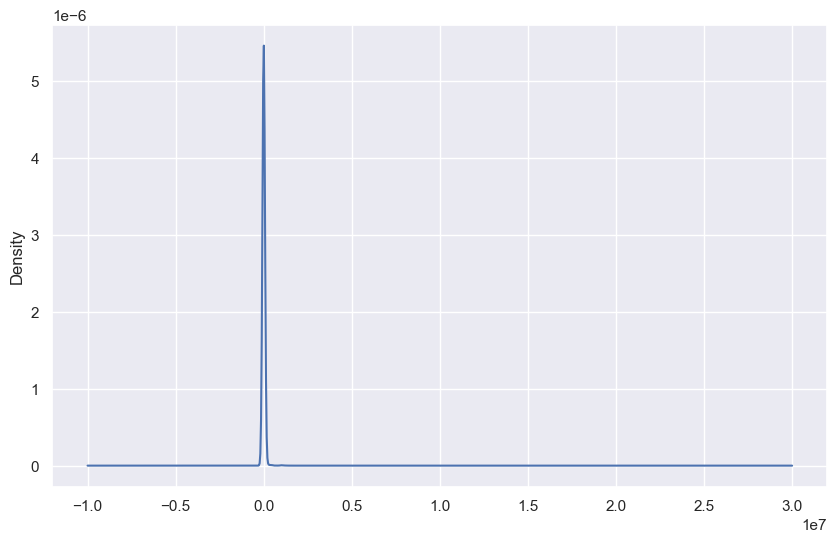

In [71]:
df.Enrollment.plot(kind = 'kde');

* The value of Skewness is 34 which means that we This feature isn't normally distributed

In [76]:
min_Value = df.Enrollment.min()
max_Value = df.Enrollment.max()
mean_Value = df.Enrollment.mean()
median_Value = df.Enrollment.median()
std_Value = df.Enrollment.std()

print(f" The min value is {min_Value} \n \
The max value is {max_Value} \n \
The mean is {mean_Value} \n \
The Median is {median_Value} \n \
The Standard Devation is {std_Value}")

 The min value is 0.0 
 The max value is 20000000.0 
 The mean is 18344.107995122802 
 The Median is 170.0 
 The Standard Devation is 404825.0038360299


 - **Large Discrepancy between Mean and Median:** The mean (18344.11) is significantly higher than the median (170.0). This substantial difference strongly suggests the presence of outliers or a skewed distribution towards higher values. The maximum value of 20,000,000.0 further supports this. Outliers can heavily inflate the mean, making it a poor representation of the "typical" enrollment value.

 - **Median's Robustness to Outliers:** The median is the middle value in a sorted dataset. It is not affected by extreme values (outliers) in the same way that the mean is. Therefore, the median provides a more stable and representative measure of the central tendency when outliers are present.

 - **Standard Deviation:** The very high standard deviation (404825.00) also indicates a large spread in the data, reinforcing the idea that using the mean might introduce artificially high values for the missing entries and distort the distribution further.

 - **Mean:** The mean is likely inflated by outliers and wouldn't represent the typical enrollment. Imputing with the mean would potentially overestimate the missing values.

 - **Minimum (0.0):** While there might be some valid zero enrollments, imputing all missing values with 0 would likely underestimate the enrollment figures and could skew the distribution towards the lower end.

 - **Maximum (20000000.0):** Imputing with the maximum value would be highly inappropriate as it would introduce extreme outliers where data is missing, completely distorting the column's distribution and any subsequent analysis.

 - **The median (170.0)** is the most robust measure of central tendency in this case due to the likely presence of outliers and the skewed distribution. Using it for imputation will likely result in a more representative and less distorted "Enrollment" column.

Number of outliers in 'Enrollment' column: 776
Percentage of outliers in 'Enrollment' column: 13.44%


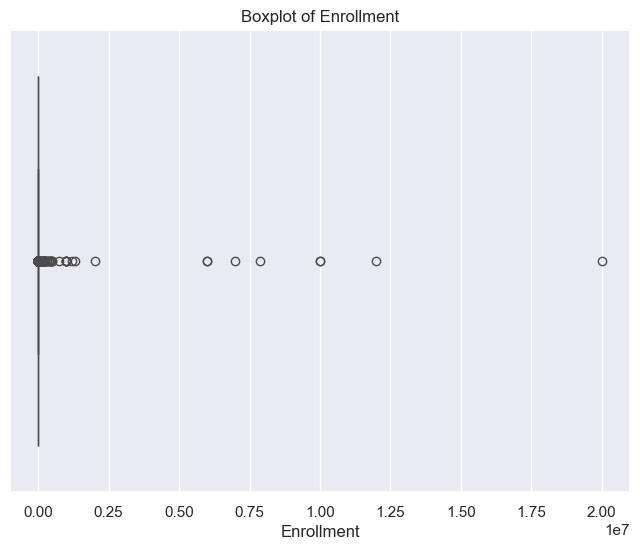

In [78]:
# 1. Identify potential outliers using the IQR method
Q1 = df['Enrollment'].quantile(0.25)
Q3 = df['Enrollment'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['Enrollment'] < lower_bound) | (df['Enrollment'] > upper_bound)]

# 2. Calculate the count and percentage of outliers
outlier_count = len(outliers)
total_count = len(df['Enrollment'])
outlier_percentage = (outlier_count / total_count) * 100

print(f"Number of outliers in 'Enrollment' column: {outlier_count}")
print(f"Percentage of outliers in 'Enrollment' column: {outlier_percentage:.2f}%")

# 3. Plot a seaborn boxplot to visualize the outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Enrollment'])
plt.title('Boxplot of Enrollment')
plt.xlabel('Enrollment')
plt.show()

In [81]:
# impute "Enrollment" by the median
df.Enrollment = df.Enrollment.fillna(median_Value)

In [82]:
df.isnull().mean() * 100

Rank                        0.000000
NCT Number                  0.000000
Title                       0.000000
Acronym                     0.000000
Status                      0.000000
Study Results               0.000000
Conditions                  0.000000
Interventions               0.000000
Outcome Measures            0.000000
Sponsor/Collaborators       0.000000
Gender                      0.000000
Age                         0.000000
Phases                      0.000000
Enrollment                  0.000000
Funded Bys                  0.000000
Study Type                  0.000000
Study Designs               0.000000
Other IDs                   0.000000
Start Date                  8.972804
Primary Completion Date    25.290144
Completion Date            26.381431
First Posted                0.000000
Results First Posted       99.376407
Last Update Posted          0.000000
Locations                   0.000000
Study Documents             0.000000
Country                     0.000000
d

## Get Country with highest contributions and barplot

In [83]:
top_10_Countires = df.Country.value_counts()[:10]
top_10_Countires

Country
 United States     1266
 France             647
nan                 583
 United Kingdom     303
 Italy              234
 Spain              233
 Turkey             218
 Canada             202
 Egypt              191
 China              171
Name: count, dtype: int64

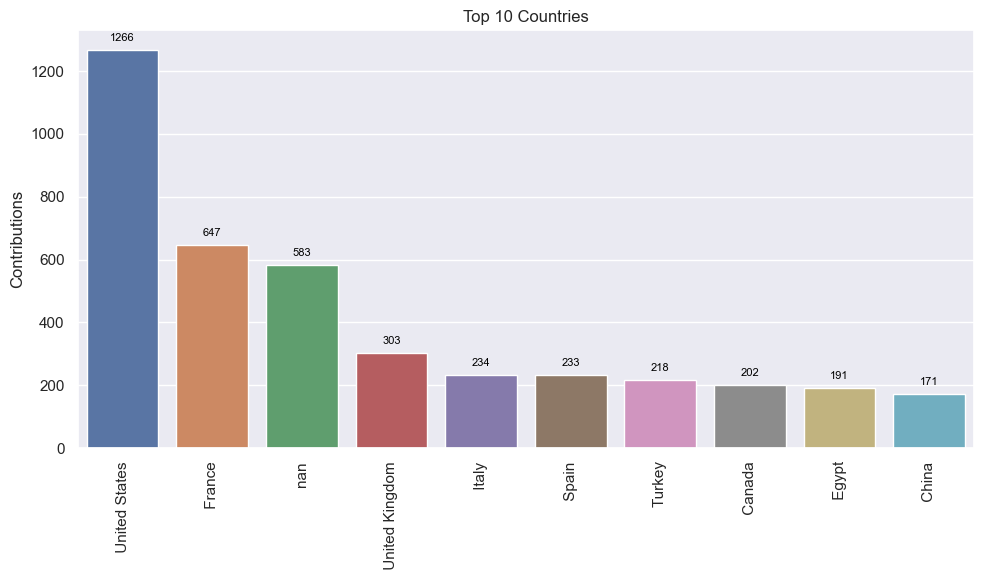

In [84]:
visualize_data(top_10_Countires, caption='Top 10 Countries', ylabel='Contributions')

## Status barplot

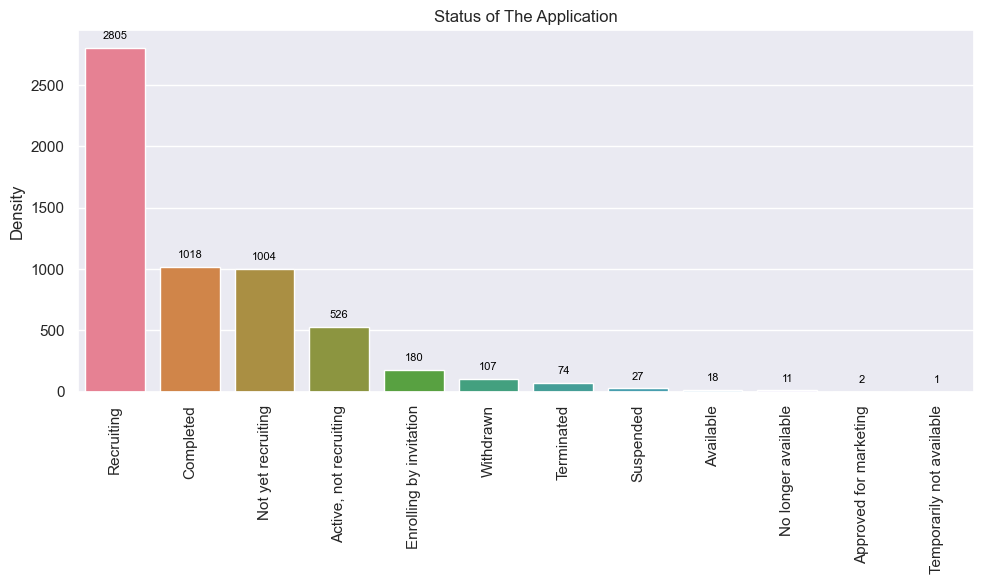

In [86]:
# Status of the Application
status = df.Status.value_counts()
visualize_data(status, caption='Status of The Application', ylabel='Density')

## Gender barplot

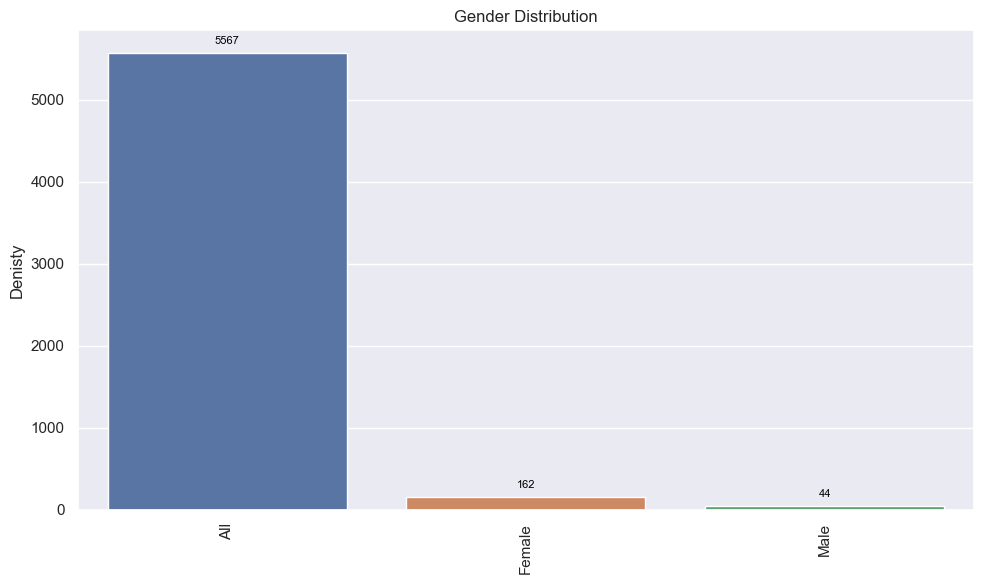

In [87]:
# Gender Visualiztions
gender = df.Gender.value_counts()
visualize_data(gender, caption='Gender Distribution', ylabel='Denisty')

## Extract short month name from feature "Start Date" and barplot

In [90]:
df.shape[0]

5773

In [88]:
df['Start Date']

0      2020-11-09
1      2020-11-02
2      2020-05-07
3      2020-05-25
4      2020-05-05
          ...    
5781   2020-03-23
5782          NaT
5783   2021-02-10
5784   2021-03-22
5785          NaT
Name: Start Date, Length: 5773, dtype: datetime64[ns]

In [94]:
# start_month = df['Start Date'].dt.month_name()
start_month = df['Start Date'].dt.strftime('%b')
start_month

0       Nov
1       Nov
2       May
3       May
4       May
       ... 
5781    Mar
5782    NaN
5783    Feb
5784    Mar
5785    NaN
Name: Start Date, Length: 5773, dtype: object

In [95]:
start_month.value_counts()

Start Date
Apr    965
May    683
Mar    623
Jun    527
Jul    377
Jan    329
Feb    327
Sep    326
Dec    283
Oct    282
Aug    276
Nov    257
Name: count, dtype: int64

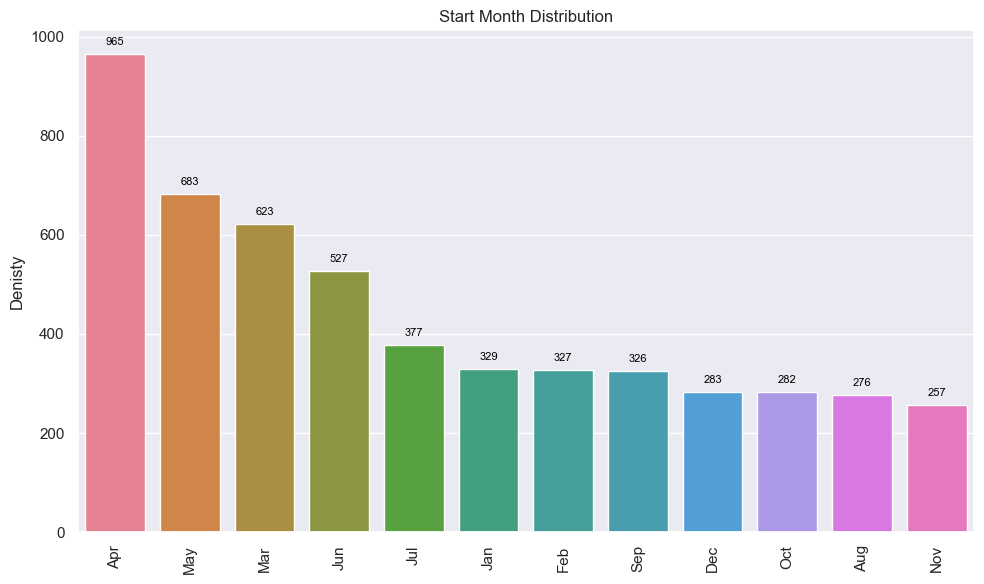

In [96]:
# Which month has the highest start

start_month = df['Start Date'].dt.strftime('%b')
start_month_Distribution = start_month.value_counts()
visualize_data(start_month_Distribution, caption='Start Month Distribution', ylabel='Denisty')

## No of unique values in feature "NCT Number"

In [98]:
print(f"The shape of data frame is {df.shape}")
print(f"Nunique in NCT Number is {df['NCT Number'].nunique()}")

The shape of data frame is (5773, 27)
Nunique in NCT Number is 5773


In [101]:
df.columns

Index(['Rank', 'NCT Number', 'Title', 'Acronym', 'Status', 'Study Results',
       'Conditions', 'Interventions', 'Outcome Measures',
       'Sponsor/Collaborators', 'Gender', 'Age', 'Phases', 'Enrollment',
       'Funded Bys', 'Study Type', 'Study Designs', 'Other IDs', 'Start Date',
       'Primary Completion Date', 'Completion Date', 'First Posted',
       'Results First Posted', 'Last Update Posted', 'Locations',
       'Study Documents', 'Country'],
      dtype='object')

## Find list of words in feature "Interventions"; make a new column and horizontal barplot

In [103]:
important_words = ["hydroxychloroquine", "convalescent", "ivermectin", "favipiravir", "tocilizumab"]

def extract_important_interventions(intervention_string):
    """
    Checks if any of the important words are present in the intervention string.
    If found, returns the first matching word; otherwise, returns None.
    """
    if isinstance(intervention_string, str):
        for word in important_words:
            if word in intervention_string.lower():  # Convert to lowercase for case-insensitive matching
                return word
    return None

# Apply the function to the 'Intervention' column to create the new column
df['Important_Interventions'] = df['Interventions'].apply(extract_important_interventions)

print(df[['Interventions', 'Important_Interventions']].head(10))

                                       Interventions Important_Interventions
0   Diagnostic Test: ID Now™ COVID-19 Screening Test                    None
1    Drug: Drug COVID19-0001-USR|Drug: normal saline                    None
2  Other: Lung CT scan analysis in COVID-19 patients                    None
3          Diagnostic Test: COVID 19 Diagnostic Test                    None
4  Diagnostic Test: Diagnosis of SARS-Cov2 by RT-...                    None
5           Biological: Convalescent COVID 19 Plasma            convalescent
6         Behavioral: COVID-19 Breastfeeding Support                    None
7                              Missing Interventions                    None
8  Diagnostic Test: Breath biopsy sampling using ...                    None
9  Biological: Convalescent Plasma from COVID-19 ...            convalescent


In [106]:
top_interventions = df['Important_Interventions'].value_counts().sort_values(ascending=False)
top_interventions

Important_Interventions
hydroxychloroquine    182
convalescent          133
ivermectin             52
tocilizumab            40
favipiravir            30
Name: count, dtype: int64

In [ ]:
# visualize_data(top_interventions, caption='Interventions', ylabel='Count')

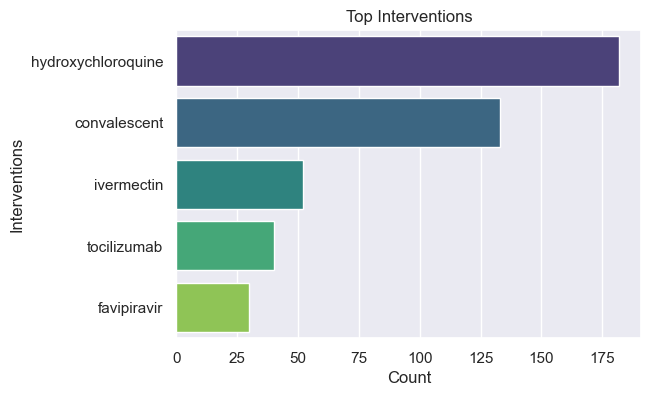

In [115]:
# palettes like 'plasma', 'magma', 'cividis', 'viridis'

plt.figure(figsize=(6, 4))
data_keys = top_interventions.keys()[:min(40, len(top_interventions))].tolist()
data_values = top_interventions.values[:min(40, len(top_interventions))].tolist()
sns.barplot(x=data_values, y=data_keys, palette='viridis')
plt.title('Top Interventions')
plt.xlabel('Count')
plt.ylabel('Interventions')
plt.show()

## Filter rows where feature "Status" is not 'Withdrawn' or Terminated'; make bins of "Enrollment" and barplot

In [127]:
df.loc[(df['Status'] != 'Withdrawn') & (df['Status'] != 'Terminated')][['Enrollment', 'Status']]

,Enrollment,Status
0,1000.0,"Active, not recruiting"
1,60.0,Not yet recruiting
2,500.0,Recruiting
3,2500.0,"Active, not recruiting"
4,50.0,Recruiting
...,...,...
5781,566.0,Recruiting
5782,200.0,Not yet recruiting
5783,88.0,Recruiting
5784,396.0,Recruiting


In [129]:
pd.cut(enrollment['Enrollment'], bins, labels=group_names)

0          >600
1         41-60
2       401-600
3           NaN
4         41-60
         ...   
5781    401-600
5782    101-200
5783     61-100
5784    201-400
5785       >600
Name: Enrollment, Length: 5592, dtype: category
Categories (8, object): ['< 20' < '21-40' < '41-60' < '61-100' < '101-200' < '201-400' < '401-600' < '>600']

In [130]:
enrollment = df.loc[(df['Status'] != 'Withdrawn') & (df['Status'] != 'Terminated')]
bins = [-1, 20, 40, 60, 100, 200, 400, 600, 1000]
group_names = ['< 20', '21-40', '41-60', '61-100', '101-200', '201-400', '401-600', '>600']
categories = pd.cut(enrollment['Enrollment'], bins, labels=group_names)
enrollment['Category'] = categories
enrollment_counts = enrollment['Category'].value_counts().sort_index(ascending=True)
enrollment_counts

Category
< 20       342
21-40      545
41-60      516
61-100     748
101-200    936
201-400    745
401-600    424
>600       427
Name: count, dtype: int64

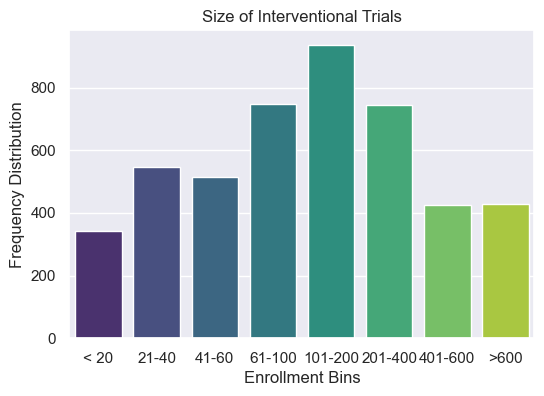

In [131]:
plt.figure(figsize=(6, 4))
data_keys = enrollment_counts.keys()[:min(40, len(enrollment_counts))].tolist()
data_values = enrollment_counts.values[:min(40, len(enrollment_counts))].tolist()
sns.barplot(x=data_keys, y=data_values, palette='viridis')
plt.title('Size of Interventional Trials')
plt.xlabel('Enrollment Bins')
plt.ylabel('Frequency Distribution')
plt.show()

## Filter, Clean, tokenize and combine strings/values in feature "Phases" and make wordcloud Image

In [132]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    # Convert the text to lowercase
    text = text.lower()
    # Remove text enclosed in square brackets
    text = re.sub('\[.*?\]', '', text)
    # Remove URLs (both HTTP/HTTPS and those starting with "www.")
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # Remove HTML tags
    text = re.sub('<.*?>+', '', text)
    # Remove punctuation marks
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # Remove newline characters
    text = re.sub('\n', '', text)
    # Remove any words that contain digits
    text = re.sub('\w*\d\w*', '', text)
    return text


def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    #remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(tokenized_text)
    return combined_text

In [134]:
df[df['Phases']=='Phase 4'].head(2)

,Rank,NCT Number,Title,Acronym,Status,Study Results,Conditions,Interventions,Outcome Measures,Sponsor/Collaborators,...,Start Date,Primary Completion Date,Completion Date,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents,Country,Important_Interventions
36,37.0,NCT04747821,An Effectiveness Study of the Sinovac's Adsorb...,Projeto S,"Active, not recruiting",No Results Available,Covid19,Biological: Adsorbed COVID-19 (Inactivated) Va...,Incidence of COVID-19 cases after two-doses im...,Butantan Institute,...,2021-02-07,NaT,NaT,2021-02-10,NaT,2021-04-08,"Hospital Estadual de Serrana, Serrana, SP, Brazil",Missing Study Documents,Brazil,None
238,239.0,NCT04710381,IMUNOR® Preparation in the Prevention of COVID-19,Missing Acronym,Not yet recruiting,No Results Available,Covid19,Drug: IMUNOR,Prevention of COVID-19 disease|Prevention of h...,University Hospital Ostrava,...,2021-02-01,2021-05-31,2021-06-30,2021-01-14,NaT,2021-01-14,"University Hospital Ostrava, Ostrava, Moravian...",Missing Study Documents,Czechia,None


In [136]:
df[df['Phases']=='Phase 4']['Title'].head(5)

36     An Effectiveness Study of the Sinovac's Adsorb...
238    IMUNOR® Preparation in the Prevention of COVID-19
242    Vitamin D Supplementation in the Prevention an...
262    Effectiveness of the Adsorbed Vaccine COVID-19...
328    A Study to Assess the Safety and Immunogenicit...
Name: Title, dtype: object

In [137]:
phase_4_trials = df[df['Phases']=='Phase 4']['Title'].apply(str).apply(lambda x: text_preprocessing(x))
phase_4_trials

36      an effectiveness study of the sinovacs adsorbe...
238               imunor preparation in the prevention of
242     vitamin d supplementation in the prevention an...
262     effectiveness of the adsorbed vaccine coronava...
328     a study to assess the safety and immunogenicit...
                              ...                        
5448    the effects of iv vs oral dexamethasone on pos...
5653    cognitive outcomes in stable renal transplant ...
5656    a pragmatic assessment of influenza vaccine ef...
5677    stop of protonpump inhibitor treatment in pati...
5760    dynamics of the immune responses to repeat inf...
Name: Title, Length: 161, dtype: object

In [146]:
phase_4_trials.shape

(161,)

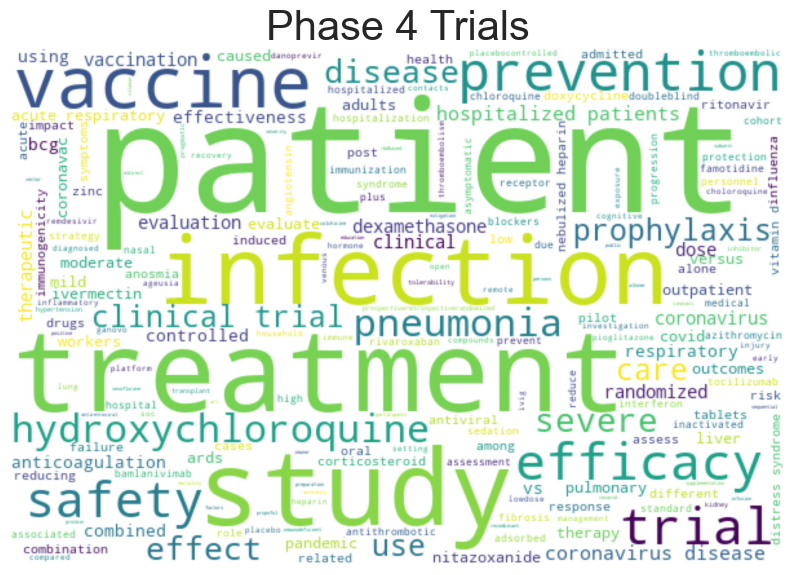

In [140]:
from wordcloud import WordCloud

wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(phase_4_trials))

plt.figure(figsize=(10, 16))
plt.title('Phase 4 Trials',fontsize=30);
plt.imshow(wordcloud1, interpolation="gaussian")
plt.axis("off")
plt.show()

In [144]:
wordcloud1

## Combine all strings from all rows of featured series "phase_4_trials" and find unique words's value counts

In [149]:
joint_str = " ".join(phase_4_trials)
joint_str

'an effectiveness study of the sinovacs adsorbed inactivated vaccine imunor preparation in the prevention of vitamin d supplementation in the prevention and mitigation of infection effectiveness of the adsorbed vaccine coronavac among education and public safety workers with risk factors for severity a study to assess the safety and immunogenicity of the coronavac vaccine against study on sequential immunization of recombinant vaccine vector and rbdbased protein subunit vaccine athome infusion using bamlanivimab in participants with mild to moderate sedation with sevoflurane versus propofol in patients with acute respiratory distress syndrome caused by infection vaccine for indirect protection vaccination of immunodeficient persons covaxid efficacy of dexamethasone treatment for patients with ards caused by colchicine and pulmonary fibrosis an outpatient clinical trial using ivermectin and doxycycline in positive patients at high risk to prevent related hospitalization effect of vitami

In [150]:
len(joint_str)

11837

In [151]:
word_count = len(joint_str.split())
word_count

1583

In [153]:
def count_unique_words(text):
    """Counts the occurrences of each unique word in a string."""
    words = text.lower().split()  # Convert to lowercase and split into words
    word_counts = {}
    for word in words:
        # Remove punctuation from the word (optional but recommended)
        cleaned_word = ''.join(char for char in word if char.isalnum())
        if cleaned_word:  # Only count non-empty cleaned words
            word_counts[cleaned_word] = word_counts.get(cleaned_word, 0) + 1
    return word_counts


unique_word_counts = count_unique_words(joint_str)
sorted_unique_word_counts = sorted(unique_word_counts.items(), key=lambda item: item[1], reverse=True)
sorted_unique_word_counts 

[('of', 111),
 ('in', 99),
 ('with', 60),
 ('patients', 59),
 ('and', 52),
 ('the', 48),
 ('for', 38),
 ('to', 30),
 ('treatment', 25),
 ('study', 21),
 ('trial', 20),
 ('infection', 16),
 ('a', 16),
 ('prevention', 14),
 ('disease', 14),
 ('vaccine', 13),
 ('on', 13),
 ('efficacy', 13),
 ('clinical', 13),
 ('coronavirus', 13),
 ('safety', 12),
 ('hydroxychloroquine', 12),
 ('pneumonia', 12),
 ('respiratory', 9),
 ('hospitalized', 9),
 ('severe', 9),
 ('or', 9),
 ('acute', 7),
 ('prophylaxis', 7),
 ('care', 7),
 ('use', 7),
 ('by', 6),
 ('vaccination', 6),
 ('dexamethasone', 6),
 ('evaluation', 6),
 ('randomized', 6),
 ('therapeutic', 6),
 ('effectiveness', 5),
 ('using', 5),
 ('syndrome', 5),
 ('effect', 5),
 ('vs', 5),
 ('combined', 5),
 ('anticoagulation', 5),
 ('controlled', 5),
 ('bcg', 5),
 ('heparin', 5),
 ('vitamin', 4),
 ('coronavac', 4),
 ('workers', 4),
 ('mild', 4),
 ('moderate', 4),
 ('versus', 4),
 ('caused', 4),
 ('ards', 4),
 ('pulmonary', 4),
 ('outpatient', 4),
 ('ive

## Clean, tokenize, filter stop words from a string "joint_str" and find unique values counts

In [159]:
# Download stopwords if you haven't already
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
except Exception as e:
    print(f"An error occurred during stopwords download: {e}")

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def text_preprocessing_with_stopwords(text):
    # 1. Clean the text
    cleaned_text = clean_text(text)

    # 2. Tokenize the cleaned text
    # Using word_tokenize (splits on whitespace and punctuation)
    # tokenized_text = word_tokenize(cleaned_text)

    # Using RegexpTokenizer (splits based on a regular expression - only alphanumeric)
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_text = tokenizer.tokenize(cleaned_text)

    # 3. Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokenized_text if word not in stop_words]

    # 4. (Optional) Join the filtered tokens back into a string
    combined_text = ' '.join(filtered_tokens)

    return filtered_tokens, combined_text # Returning the list of tokens

processed_tokens, combined_filtered_tokens = text_preprocessing_with_stopwords(joint_str)

In [160]:
print(processed_tokens)

['effectiveness', 'study', 'sinovacs', 'adsorbed', 'inactivated', 'vaccine', 'imunor', 'preparation', 'prevention', 'vitamin', 'supplementation', 'prevention', 'mitigation', 'infection', 'effectiveness', 'adsorbed', 'vaccine', 'coronavac', 'among', 'education', 'public', 'safety', 'workers', 'risk', 'factors', 'severity', 'study', 'assess', 'safety', 'immunogenicity', 'coronavac', 'vaccine', 'study', 'sequential', 'immunization', 'recombinant', 'vaccine', 'vector', 'rbdbased', 'protein', 'subunit', 'vaccine', 'athome', 'infusion', 'using', 'bamlanivimab', 'participants', 'mild', 'moderate', 'sedation', 'sevoflurane', 'versus', 'propofol', 'patients', 'acute', 'respiratory', 'distress', 'syndrome', 'caused', 'infection', 'vaccine', 'indirect', 'protection', 'vaccination', 'immunodeficient', 'persons', 'covaxid', 'efficacy', 'dexamethasone', 'treatment', 'patients', 'ards', 'caused', 'colchicine', 'pulmonary', 'fibrosis', 'outpatient', 'clinical', 'trial', 'using', 'ivermectin', 'doxycyc

In [161]:
print(combined_filtered_tokens)

effectiveness study sinovacs adsorbed inactivated vaccine imunor preparation prevention vitamin supplementation prevention mitigation infection effectiveness adsorbed vaccine coronavac among education public safety workers risk factors severity study assess safety immunogenicity coronavac vaccine study sequential immunization recombinant vaccine vector rbdbased protein subunit vaccine athome infusion using bamlanivimab participants mild moderate sedation sevoflurane versus propofol patients acute respiratory distress syndrome caused infection vaccine indirect protection vaccination immunodeficient persons covaxid efficacy dexamethasone treatment patients ards caused colchicine pulmonary fibrosis outpatient clinical trial using ivermectin doxycycline positive patients high risk prevent related hospitalization effect vitamin morbidity mortality ivermectin vs combined hydroxychloroquine antiretroviral drugs art among asymptomatic infection efficacy nasal spray containing iotacarrageenan p

In [162]:
unique_word_counts = count_unique_words(combined_filtered_tokens)
sorted_unique_word_counts = sorted(unique_word_counts.items(), key=lambda item: item[1], reverse=True)
sorted_unique_word_counts

[('patients', 59),
 ('treatment', 25),
 ('study', 21),
 ('trial', 20),
 ('infection', 16),
 ('prevention', 14),
 ('disease', 14),
 ('vaccine', 13),
 ('efficacy', 13),
 ('clinical', 13),
 ('coronavirus', 13),
 ('safety', 12),
 ('hydroxychloroquine', 12),
 ('pneumonia', 12),
 ('respiratory', 9),
 ('hospitalized', 9),
 ('severe', 9),
 ('acute', 7),
 ('prophylaxis', 7),
 ('care', 7),
 ('use', 7),
 ('vaccination', 6),
 ('dexamethasone', 6),
 ('evaluation', 6),
 ('randomized', 6),
 ('therapeutic', 6),
 ('effectiveness', 5),
 ('using', 5),
 ('syndrome', 5),
 ('effect', 5),
 ('vs', 5),
 ('combined', 5),
 ('anticoagulation', 5),
 ('controlled', 5),
 ('bcg', 5),
 ('heparin', 5),
 ('vitamin', 4),
 ('coronavac', 4),
 ('workers', 4),
 ('mild', 4),
 ('moderate', 4),
 ('versus', 4),
 ('caused', 4),
 ('ards', 4),
 ('pulmonary', 4),
 ('outpatient', 4),
 ('ivermectin', 4),
 ('liver', 4),
 ('nitazoxanide', 4),
 ('therapy', 4),
 ('outcomes', 4),
 ('adults', 4),
 ('covid', 4),
 ('pandemic', 4),
 ('evaluate